In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
import pandas as pd
import numpy.ma as ma

### get data

In [2]:
##Oliver MJO
df=pd.read_csv("/Users/dongxiay/Documents/data/MJO_ot12.csv")
df['time']=pd.date_range(start='1/1/1905',end='31/12/2014',freq='D')
df=df.set_index('time')
df=df.drop(columns=['year','month','day'])
df.loc[df['amplitude']<1,'phase']=0

df
# df=df.merge(df2['watch'],how='inner',on='time')
# # df=df.loc[df['watch']==-1]

,IHR1,IHR2,amplitude,phase
time,,,,
1905-01-01,-0.33030,1.14170,1.18850,7
1905-01-02,-0.31931,1.28760,1.32660,7
1905-01-03,-0.33541,1.43210,1.47080,7
1905-01-04,-0.37670,1.52620,1.57200,7
1905-01-05,-0.41831,1.54130,1.59700,7
...,...,...,...,...
2014-12-27,1.29780,-0.91191,1.58620,4
2014-12-28,1.39010,-0.70043,1.55660,4
2014-12-29,1.32880,-0.36517,1.37810,4


In [3]:
##----------------------------------------------------
##NINO3.4, monthly resample to daily, nino34>1 elnino, nino34<-1 lanina, else neatural
##----------------------------------------------------
nino=pd.read_csv("https://psl.noaa.gov/data/correlation/nina34.anom.data",
                sep='  ', skiprows=3,skipfooter=4,names=np.arange(1,13))
nino=nino.reset_index()
nino_long = pd.melt(nino,id_vars='index')
nino_long = nino_long.rename(columns={'index':'year','variable':'month'})
nino_long['day'] = 1
nino_long['time'] = pd.to_datetime(nino_long[['year','month','day']])
nino_long = nino_long[['time','value']]
nino_long = nino_long.set_index('time').resample('1d').ffill()

nino_long.loc[nino_long['value']<(-1) ,'watch'] = -1
nino_long.loc[nino_long['value']>(1) ,'watch'] = 1
nino_long.loc[(nino_long['value']>(-1)) & (nino_long['value']<(1)),'watch']=0

df2=nino_long
df2

/Users/dongxiay/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,value,watch
time,,
1950-01-01,-1.99,-1.0
1950-01-02,-1.99,-1.0
1950-01-03,-1.99,-1.0
1950-01-04,-1.99,-1.0
1950-01-05,-1.99,-1.0
...,...,...
2022-11-27,-0.90,0.0
2022-11-28,-0.90,0.0
2022-11-29,-0.90,0.0


### select MJO events following Ren&Wei 2019

In [4]:
rmm2=df['IHR2']['1950-01-01':'2015-01-01'].to_frame()
localmin=rmm2['IHR2'].mean() - rmm2['IHR2'].std()
rmm2['gt1']=rmm2['IHR2']>1

#### this is just an example to showcase which MJO event is selected

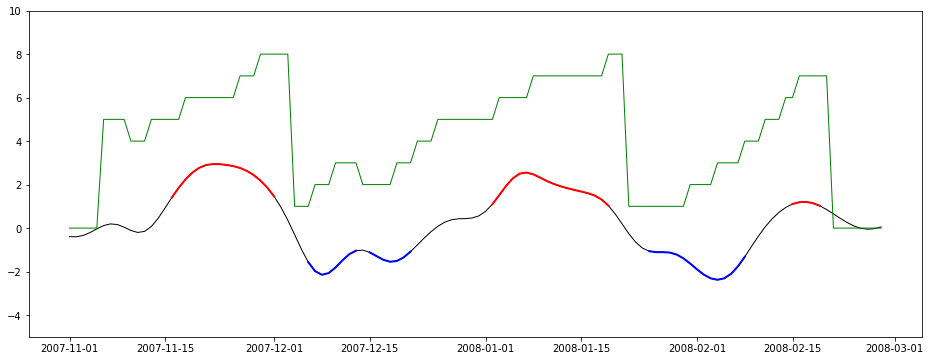

In [5]:
lanina07=rmm2['IHR2']['2007-11-01':'2008-02-28']
df1 = rmm2['2007-11-01':'2008-02-28'].iloc[::-1].rolling(7)['gt1'].sum().iloc[::-1]
t=lanina07.index.values
y=lanina07.values
y2=df['phase']['2007-11-01':'2008-02-28']
y3=df1['2007-11-01':'2008-02-28']

# generate the masked array
mask1 = ma.masked_less(y, 1)
mask2 = ma.masked_greater(y, localmin)

plt.figure(figsize=(16,6))
plt.ylim([-5, 10])
plt.plot(t, y, 'k', linewidth=1)
plt.plot(t, mask1, 'r', linewidth=2)
plt.plot(t, mask2, 'b', linewidth=2)

plt.plot(t, y2, 'green', linewidth=1)
# plt.plot(t, y3, 'purple', linewidth=1)

#### Selection criteria for MJO events:
MJO starting phase <=2 and RMM2 < one negative standard division, and define this as day 0;
After day-0, the RMM2 should increase and remain high ( >1) for at least 7 days;
MJO ending phase >=4.

In [6]:
#select events when MJO experienced phase 2-4/5/6/7/8

fz=df['phase']['1950-01-01':'2015-01-01'].copy()
fz=fz.reset_index()

fz['decrease'] = fz['phase'] < fz['phase'].shift(1)

fz['break'] = fz['decrease'].cumsum()

periods_by_phase = pd.DataFrame(
    {
        'start_time': fz.groupby('break')['time'].first(),
        'start_phase': fz.groupby('break')['phase'].first(),
        'le2_max_time': fz.groupby('break').apply(lambda x: x[x['phase']<=2]['time'].max()),
        'end_time': fz.groupby('break')['time'].last(),
        'end_phase': fz.groupby('break')['phase'].last(),
    }
)

periods_by_phase = periods_by_phase.query('start_phase<=2 and end_phase>=4')

In [7]:
found_periods = pd.DataFrame()
for _,d in periods_by_phase.iterrows():
    if rmm2.loc[d['start_time']:d['le2_max_time']]['IHR2'].min() <= localmin:
        rmm2_ = rmm2.loc[d['start_time']:d['end_time']].copy()
        rmm2_['gt1']=rmm2_['IHR2']>1
        rolling_count = rmm2_.iloc[::-1].rolling(7)['gt1'].sum().iloc[::-1]
        if 7 in rolling_count.values:
            found_periods = found_periods.append(d[['start_time', 'end_time']])

In [8]:
found_periods

,start_time,end_time
3,1950-01-29,1950-03-05
22,1951-01-16,1951-03-06
27,1951-05-15,1951-06-19
37,1951-12-23,1952-01-30
76,1954-01-06,1954-02-09
...,...,...
1066,2009-10-30,2009-12-07
1076,2010-03-12,2010-04-08
1094,2011-03-11,2011-04-09
1111,2012-02-11,2012-03-27


#### for the above MJO events, separate them into Elnino and Lanina years based on ENSO index (df2)

In [29]:
# Create an empty dataframe called "ElNino"
ElNino_year = pd.DataFrame(columns=["start_time", "end_time"])
LaNina_year = pd.DataFrame(columns=["start_time", "end_time"])

# Loop through each row offound_periods and select the corresponding values from df2
for index, row in found_periods.iterrows():
    start_time = row["start_time"]
    end_time = row["end_time"]
    
    # Select the values from df2 corresponding to the time period
    values = df2.loc[start_time:end_time, "value"].mean()
    
   # Check if the mean of the selected values is not equal to zero
    if values >= 0.5:
        ElNino_year = ElNino_year.append({"start_time": start_time, "end_time": end_time}, ignore_index=True)
    elif values <=-0.5: 
        LaNina_year = LaNina_year.append({"start_time": start_time, "end_time": end_time}, ignore_index=True)    

In [30]:
ElNino_year["start_time"].tolist()

[Timestamp('1957-10-18 00:00:00'),
 Timestamp('1957-11-27 00:00:00'),
 Timestamp('1963-11-23 00:00:00'),
 Timestamp('1966-03-06 00:00:00'),
 Timestamp('1973-01-02 00:00:00'),
 Timestamp('1976-10-29 00:00:00'),
 Timestamp('1978-01-06 00:00:00'),
 Timestamp('1986-10-19 00:00:00'),
 Timestamp('1987-09-28 00:00:00'),
 Timestamp('1987-12-01 00:00:00'),
 Timestamp('1995-01-03 00:00:00'),
 Timestamp('1995-02-16 00:00:00'),
 Timestamp('1997-12-11 00:00:00'),
 Timestamp('2002-05-31 00:00:00'),
 Timestamp('2002-10-29 00:00:00'),
 Timestamp('2009-10-30 00:00:00'),
 Timestamp('2010-03-12 00:00:00')]

In [31]:
LaNina_year["start_time"].tolist()

[Timestamp('1950-01-29 00:00:00'),
 Timestamp('1951-01-16 00:00:00'),
 Timestamp('1954-11-24 00:00:00'),
 Timestamp('1955-04-30 00:00:00'),
 Timestamp('1955-08-22 00:00:00'),
 Timestamp('1959-10-14 00:00:00'),
 Timestamp('1962-11-20 00:00:00'),
 Timestamp('1967-05-08 00:00:00'),
 Timestamp('1968-03-02 00:00:00'),
 Timestamp('1970-09-10 00:00:00'),
 Timestamp('1973-06-24 00:00:00'),
 Timestamp('1974-03-24 00:00:00'),
 Timestamp('1974-12-26 00:00:00'),
 Timestamp('1975-12-24 00:00:00'),
 Timestamp('1978-04-15 00:00:00'),
 Timestamp('1981-07-02 00:00:00'),
 Timestamp('1985-01-22 00:00:00'),
 Timestamp('1985-05-11 00:00:00'),
 Timestamp('1985-09-12 00:00:00'),
 Timestamp('1985-11-28 00:00:00'),
 Timestamp('1988-05-03 00:00:00'),
 Timestamp('2000-12-29 00:00:00'),
 Timestamp('2006-01-02 00:00:00'),
 Timestamp('2007-12-14 00:00:00'),
 Timestamp('2009-01-19 00:00:00'),
 Timestamp('2011-03-11 00:00:00'),
 Timestamp('2012-02-11 00:00:00')]